In [46]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.linear_model import Lasso
from sklearn.metrics import precision_score, classification_report
import warnings

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

def prepare_data(ticker):
    print(f"\n[+] Processing {ticker}...")
    data = yf.download(ticker, start="2021-01-01", progress=False)
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)

    # FEATURES
    data.ta.sma(length=50, append=True)
    data['Price_vs_SMA50'] = data['Close'] / data['SMA_50']
    data['RSI'] = data.ta.rsi(length=14)
    data['RSI_Diff'] = data['RSI'] - data['RSI'].shift(1)
    data.ta.obv(append=True)
    data['Vol_Rel'] = data['Volume'] / data['Volume'].rolling(20).mean()
    data.ta.atr(length=14, append=True)
    data['ATR_Ratio'] = data['ATRr_14'] / data['ATRr_14'].rolling(20).mean()
    
    # TARGET: 5-Day Trend
    data['Target_5Day'] = (data['Close'].shift(-5) > data['Close']).astype(int)
    data.dropna(inplace=True)
    return data

In [47]:
def train_and_report(data, ticker):
    features = ['RSI', 'RSI_Diff', 'Price_vs_SMA50', 'OBV', 'ATR_Ratio', 'Vol_Rel']
    X = data[features]
    y = data['Target_5Day']
    
    # 70:30 SPLIT
    split = int(len(data) * 0.70)
    X_train, X_test = X.iloc[:split], X.iloc[split:]
    y_train, y_test = y.iloc[:split], y.iloc[split:]
    
    print(f"--- {ticker} DATA SHAPES ---")
    print(f"Training set: {X_train.shape} | Testing set: {X_test.shape}")

    #LASSO BASELINE
    lasso = Lasso(alpha=0.001)
    lasso.fit(X_train, y_train)
    # Best threshold for Lasso: 0.55
    l_preds = (lasso.predict(X_test) > 0.55).astype(int)
    l_prec = precision_score(y_test, l_preds, zero_division=0)
    print(f"\nLASSO CLASSIFICATION REPORT ({ticker}):")
    print(classification_report(y_test, l_preds))

    # XGBOOST SNIPER
    # We use simpler trees (depth 2) and more regularization to match Lasso's success
    xgb = XGBClassifier(n_estimators=200, max_depth=2, learning_rate=0.01, 
                        reg_alpha=0.1, reg_lambda=1, random_state=42)
    xgb.fit(X_train, y_train)
    
    probs = xgb.predict_proba(X_test)[:, 1]
    
    # SNIPER FILTER: High Confidence (0.70) + Price > SMA50
    conf_filter = (probs > 0.62)
    trend_filter = (X_test['Price_vs_SMA50'] > 1.0) # Price must be in uptrend
    
    x_preds = (conf_filter & trend_filter).astype(int)
    x_prec = precision_score(y_test, x_preds, zero_division=0)
    
    print(f"XGB-Sniper Precision: {x_prec:.2%} | Trades: {sum(x_preds)}")
    
    return l_prec, x_prec, l_preds, x_preds, X_test.index

In [48]:
tickers = ['TATAELXSI.NS', 'PERSISTENT.NS']
results = {}

print(f"{'Ticker':<15} | {'Lasso Precision':<18} | {'XGB Sniper Precision':<20} | {'Winner'}")
print("-" * 80)

for t in tickers:
    df = prepare_data(t)
    
    # FIX 1: Use 'train_and_report' (the name you defined in Cell 2)
    l_prec, x_prec, l_preds, x_preds, test_index = train_and_report(df, t)
    
    # FIX 2: Determine the winner using the local variables l_prec and x_prec
    winner = "Lasso" if l_prec > x_prec else "XGBoost"
    if l_prec == x_prec == 0: 
        winner = "None"
    
    # FIX 3: Store results with the correct keys for the visualizer
    results[t] = {
        'data': df, 
        'idx': test_index,      
        'l_preds': l_preds, 
        'x_preds': x_preds, 
        'winner': winner,
        'l_score': l_prec,
        'x_score': x_prec
    }
    
    # FIX 4: Use l_prec and x_prec for printing
    print(f"{t:<15} | {l_prec:.2%}           | {x_prec:.2%}             | {winner}")

Ticker          | Lasso Precision    | XGB Sniper Precision | Winner
--------------------------------------------------------------------------------

[+] Processing TATAELXSI.NS...
--- TATAELXSI.NS DATA SHAPES ---
Training set: (854, 6) | Testing set: (367, 6)

LASSO CLASSIFICATION REPORT (TATAELXSI.NS):
              precision    recall  f1-score   support

           0       0.61      1.00      0.76       219
           1       1.00      0.05      0.09       148

    accuracy                           0.62       367
   macro avg       0.80      0.52      0.42       367
weighted avg       0.77      0.62      0.49       367

XGB-Sniper Precision: 75.00% | Trades: 4
TATAELXSI.NS    | 100.00%           | 75.00%             | Lasso

[+] Processing PERSISTENT.NS...
--- PERSISTENT.NS DATA SHAPES ---
Training set: (854, 6) | Testing set: (367, 6)

LASSO CLASSIFICATION REPORT (PERSISTENT.NS):
              precision    recall  f1-score   support

           0       0.46      0.97      0.63  

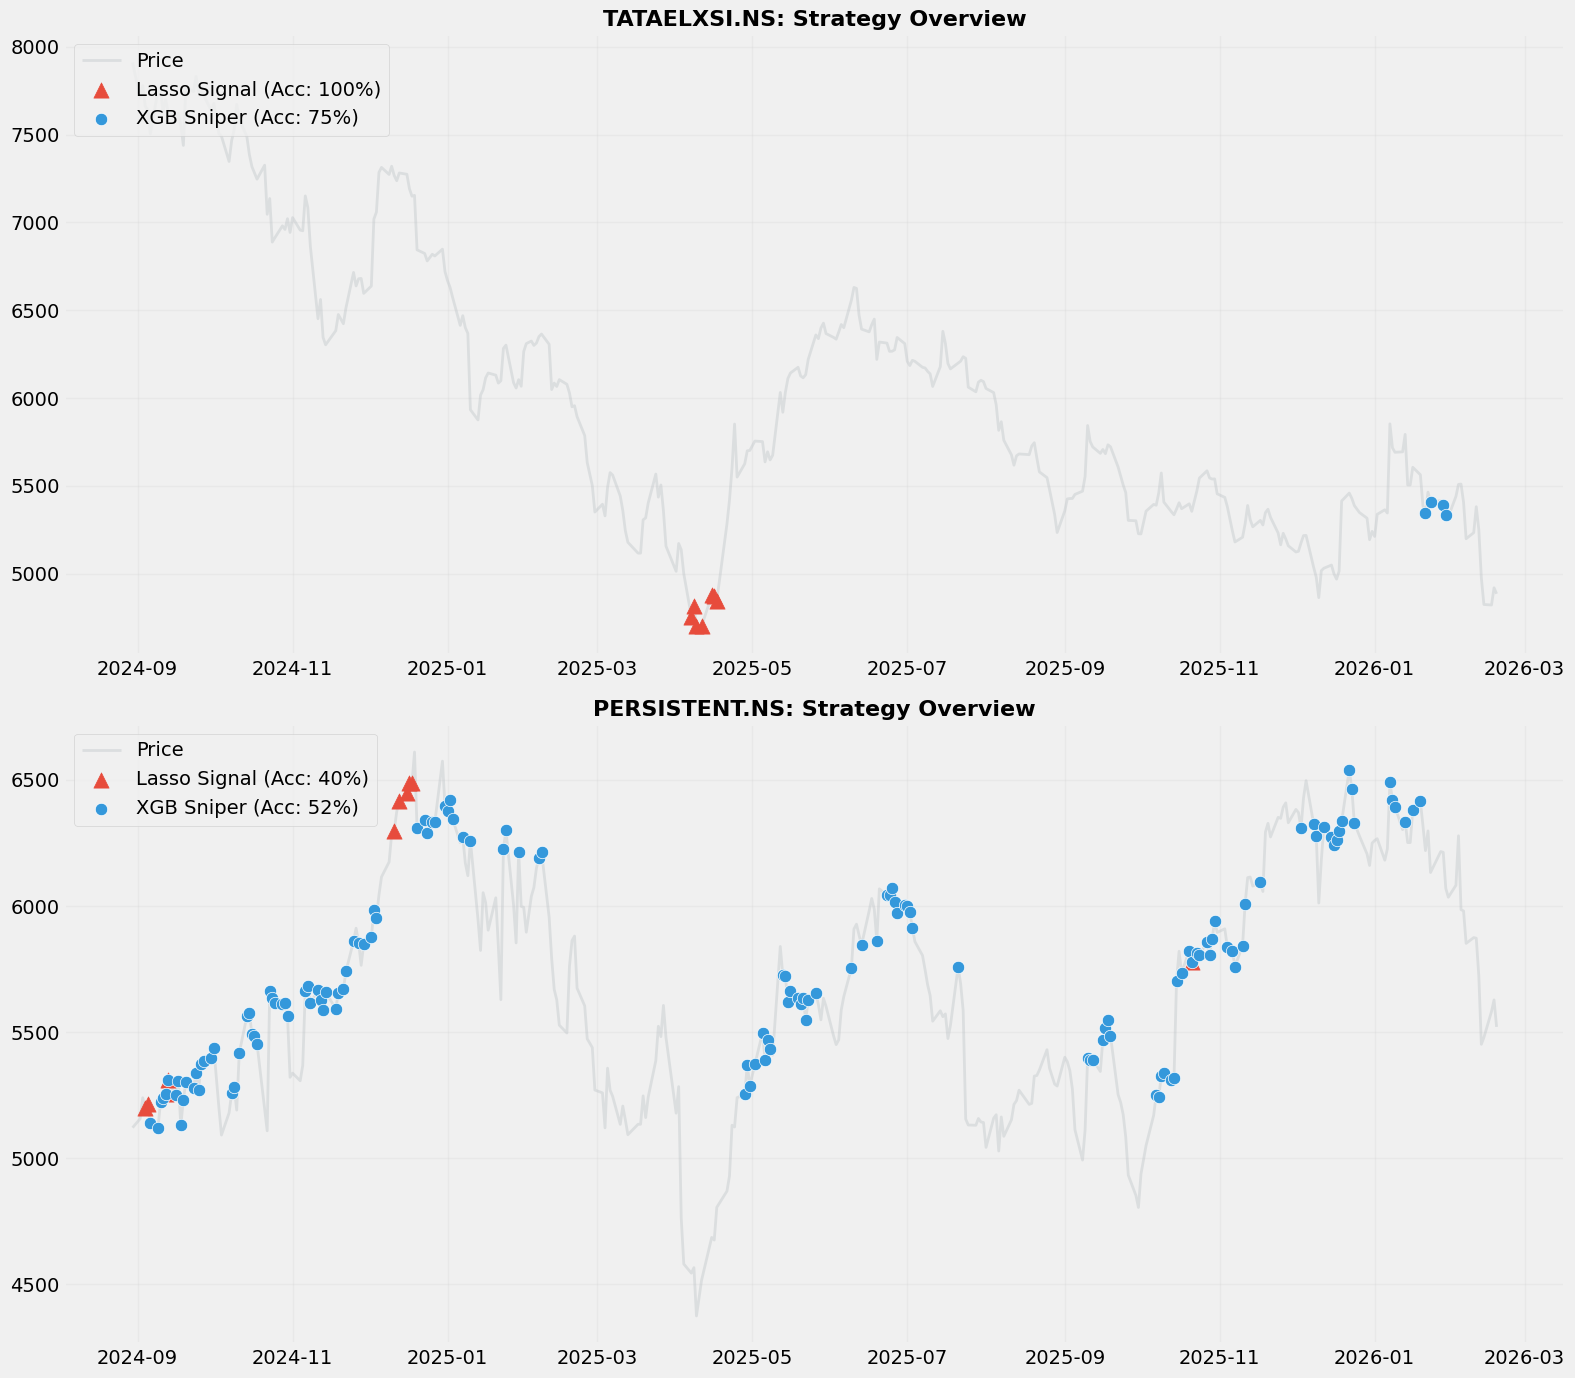


   STRATEGY EXECUTION LOG

STOCK: TATAELXSI.NS
Model        | Total Trades    | Execution Dates
Lasso        | 7               | 2025-04-07, 2025-04-08, 2025-04-09, 2025-04-11, 2025-04-15, 2025-04-16, 2025-04-17
XGB Sniper   | 4               | 2026-01-21, 2026-01-23, 2026-01-28, 2026-01-29

STOCK: PERSISTENT.NS
Model        | Total Trades    | Execution Dates
Lasso        | 10              | 2024-09-04, 2024-09-05, 2024-09-12, 2024-09-13, 2024-12-11, 2024-12-13, 2024-12-16, 2...
XGB Sniper   | 143             | 2024-09-06, 2024-09-09, 2024-09-10, 2024-09-11, 2024-09-12, 2024-09-13, 2024-09-16, 2...


In [49]:
#VISUALS + TRADING LOG
fig, ax = plt.subplots(2, 1, figsize=(16, 14))
for i, t in enumerate(tickers):
    res = results[t]
    df, dates = res['data'], res['idx']
    
    # 1. Plot Base Price (Clean background)
    ax[i].plot(df.loc[dates, 'Close'], label='Price', color='#bdc3c7', alpha=0.4, linewidth=2)
    
    # 2. Extract Signals
    l_dates = dates[res['l_preds'] == 1]
    x_dates = dates[res['x_preds'] == 1]
    
    # 3. Plot Signals (No ugly text on chart)
    if len(l_dates) > 0:
        ax[i].scatter(l_dates, df.loc[l_dates, 'Close'], marker='^', color='#e74c3c', s=120, 
                      label=f"Lasso Signal (Acc: {res['l_score']:.0%})", zorder=5)

    if len(x_dates) > 0:
        ax[i].scatter(x_dates, df.loc[x_dates, 'Close'], marker='o', color='#3498db', s=80, 
                      label=f"XGB Sniper (Acc: {res['x_score']:.0%})", zorder=6, edgecolors='white')

    ax[i].set_title(f"{t}: Strategy Overview", fontsize=16, fontweight='bold')
    ax[i].legend(loc='upper left')
    ax[i].grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

#THE TRADING LOG LISTS
print("\n   STRATEGY EXECUTION LOG")

for t in tickers:
    res = results[t]
    l_dates = res['idx'][res['l_preds'] == 1]
    x_dates = res['idx'][res['x_preds'] == 1]
    
    print(f"\nSTOCK: {t}")
    print(f"{'Model':<12} | {'Total Trades':<15} | {'Execution Dates'}")
    
    # Format dates into a clean comma-separated string
    l_str = ", ".join([d.strftime('%Y-%m-%d') for d in l_dates]) if len(l_dates) > 0 else "No trades"
    x_str = ", ".join([d.strftime('%Y-%m-%d') for d in x_dates]) if len(x_dates) > 0 else "No trades"
    
    # Print Lasso Log (Limit display if too many trades)
    print(f"{'Lasso':<12} | {len(l_dates):<15} | {l_str[:85]}..." if len(l_str) > 85 else f"{'Lasso':<12} | {len(l_dates):<15} | {l_str}")
    
    # Print XGB Log
    print(f"{'XGB Sniper':<12} | {len(x_dates):<15} | {x_str[:85]}..." if len(x_str) > 85 else f"{'XGB Sniper':<12} | {len(x_dates):<15} | {x_str}")